In [1]:
!pip install gdown

In [2]:
from torchvision import transforms, datasets
from PIL import Image
import pandas as pd
import os
import numpy as np
import argparse
import wandb
import torch
from tqdm import tqdm
from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights, efficientnet_b4, EfficientNet_B4_Weights, efficientnet_b0, EfficientNet_B0_Weights
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR, ExponentialLR, CosineAnnealingLR

In [2]:
try:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    api_key = user_secrets.get_secret("wandb_api")
    wandb.login(key=api_key)
    anony = None
except:
    anony = "must"
    print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')

If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. 
Get your W&B access token from here: https://wandb.ai/authorize


In [3]:
!gdown --id 11rK4cxUSyWSPWrRZ9Hhym8ovDmY-v9D1 -O clothes.zip
!unzip -q clothes.zip -d data

/opt/conda/lib/python3.10/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=11rK4cxUSyWSPWrRZ9Hhym8ovDmY-v9D1
From (redirected): https://drive.google.com/uc?id=11rK4cxUSyWSPWrRZ9Hhym8ovDmY-v9D1&confirm=t&uuid=97ed1295-59d3-4793-ac60-d81da90b23a7
To: /kaggle/working/clothes.zip
100%|█████████████████████████████████████████| 907M/907M [00:08<00:00, 102MB/s]


In [4]:
def count_images_in_classes(root_dir):
    class_counts = {}
    
    # Traverse through all directories (classes)
    for class_name in os.listdir(root_dir):
        class_path = os.path.join(root_dir, class_name)
        
        # Only consider directories (classes)
        if os.path.isdir(class_path):
            # Count number of images in the class directory
            num_images = len([f for f in os.listdir(class_path) if f.endswith(('.jpg', '.png', '.jpeg'))])  # Adjust extensions as necessary
            class_counts[class_name] = num_images
            
    return class_counts

# def calculate_class_weights(class_counts, total_images):
#     # Calculate the weights as the inverse of class frequency
#     weights = {}
#     for class_name, count in class_counts.items():
#         weights[class_name] = total_images / count
    
#     # Normalize the weights to sum to 1 (optional, you can skip this if you want raw weights)
#     total_weight = sum(weights.values())
#     normalized_weights = {class_name: weight / total_weight for class_name, weight in weights.items()}
    
#     return normalized_weights

def calculate_class_weights(class_counts, total_images):
    # Calculate the weights as the inverse of class frequency (no normalization)
    weights = {}
    for class_name, count in class_counts.items():
        weights[class_name] = total_images / count  # Inverse frequency
    
    return weights


In [13]:
def calculate_mean_and_std(image_size, dataset_path):
    # Define the transformation to resize and convert images to tensors
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),  # Convert images to Tensor
    ])
    
    # Load the dataset with the defined transformations
    dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
    
    # Initialize variables to accumulate sums and squared sums for each channel
    channels_sum = torch.zeros(3)
    channels_squared_sum = torch.zeros(3)
    num_pixels = 0
    
    # Iterate over the dataset in batches using tqdm to show progress
    for images, _ in tqdm(dataloader, desc="Calculating Mean and Std", ncols=100, total=len(dataloader)):
        batch_samples = images.size(0)  # Number of images in the batch
        num_pixels += batch_samples * images.size(2) * images.size(3)  # Height * Width * Batch Size
        
        # Accumulate the sum and squared sum for each channel
        channels_sum += images.sum(dim=[0, 2, 3])  # Sum over batch and spatial dimensions (H, W)
        channels_squared_sum += (images ** 2).sum(dim=[0, 2, 3])  # Sum of squared values

    # Calculate the mean and std for each channel
    mean = channels_sum / num_pixels
    std = torch.sqrt(channels_squared_sum / num_pixels - mean ** 2)

    print(f"Mean: {mean}")
    print(f"Std: {std}")

In [9]:
calculate_mean_and_std(300, '/kaggle/working/data/data_new/train')

Calculating Mean and Std: 100%|███████████████████████████████████| 238/238 [01:09<00:00,  3.43it/s]

Mean: tensor([0.6303, 0.5767, 0.5651])
Std: tensor([0.3210, 0.3099, 0.3067])


In [28]:
calculate_mean_and_std(380, '/kaggle/working/data/data_new/train')

Calculating Mean and Std: 100%|███████████████████████████████████| 238/238 [01:22<00:00,  2.88it/s]

Mean: tensor([0.6303, 0.5767, 0.5651])
Std: tensor([0.3216, 0.3106, 0.3073])


In [5]:
def get_mean_std(image_size):
    # Predefined mean and std values for specific image sizes
    if image_size == 300:
        return [0.6303, 0.5767, 0.5651], [0.3210, 0.3099, 0.3067]
    
    elif image_size == 380:
        return [0.6303, 0.5767, 0.5651], [0.3216, 0.3106, 0.3073]

    else:
        raise ValueError(f"Unsupported image size: {image_size}")


In [6]:
def resize_with_padding(img, target_size):
    """Resize the image while maintaining the aspect ratio and pad with zeros."""
    width, height = img.size
    aspect_ratio = width / height

    if aspect_ratio > 1:
        # Image is wider than tall
        new_width = target_size
        new_height = int(target_size / aspect_ratio)
    else:
        # Image is taller than wide
        new_height = target_size
        new_width = int(target_size * aspect_ratio)

    img = img.resize((new_width, new_height), Image.Resampling.LANCZOS)

    # Create a new image with padding (black padding by default)
    new_img = Image.new("RGB", (target_size, target_size), (0, 0, 0))  # Black padding

    # Calculate padding
    padding_top = (target_size - new_height) // 2
    padding_left = (target_size - new_width) // 2

    # Paste the resized image into the center of the padding
    new_img.paste(img, (padding_left, padding_top))

    return new_img


def load_dataset(data_dir, image_size, mode='train'):
    """
    Loads dataset from the given directory (like ImageFolder) with specified transformations.

    :param data_dir: Directory containing the dataset
    :param image_size: The target size to resize the images
    :param mode: 'train' or 'test' for the dataset split
    :return: A dataset object
    """
    mean, std = get_mean_std(image_size)
    # Define transformations
    if mode == 'train':
        # Train set transformations: Augmentations + Resize with Padding
        transform_pipeline = transforms.Compose([
            transforms.RandomHorizontalFlip(),           # Random horizontal flip
            transforms.RandomRotation(10),               # Random rotation between -10 and 10 degrees
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Random color jitter
            transforms.Lambda(lambda img: resize_with_padding(img, image_size)),  # Resize and pad
            transforms.ToTensor(),                       # Convert image to tensor
            transforms.Normalize(mean=mean, std=std)  # Normalize image
        ])
    else:
        # Test set transformations: Resize with Padding + Normalization
        transform_pipeline = transforms.Compose([
            transforms.Lambda(lambda img: resize_with_padding(img, image_size)),  # Resize and pad
            transforms.ToTensor(),                       # Convert image to tensor
            transforms.Normalize(mean=mean, std=std)  # Normalize image
        ])

    # Use ImageFolder to load the dataset
    dataset = datasets.ImageFolder(root=data_dir, transform=transform_pipeline)

    return dataset


In [7]:
class CustomMSELossWithGroupPenalty(nn.Module):
    def __init__(self, penalty_factor=2.0, class_weights=None):
        super(CustomMSELossWithGroupPenalty, self).__init__()
        self.class_names = [
            "ao_2_day", "ao_ba_lo", "ao_da", "ao_dai", "ao_khoac_the_thao", "ao_len",
            "ao_mangto", "ao_so_mi", "ao_thun", "ao_tre_vai", "ao_vest", "chan_vay_dai",
            "chan_vay_ngan", "dam_maxi", "dam_om", "do_ngu_do_mac_nha", "quan_dai", "quan_jean", "quan_short"
        ]
        # Create a mapping from class names to groups
        self.class_to_group = self.create_class_to_group_mapping()
        
        # Penalty factor for different groups
        self.penalty_factor = penalty_factor
        
        # Store the class weights if provided
        self.class_weights = class_weights if class_weights is not None else {}

    def create_class_to_group_mapping(self):
        # Mapping each class name to a group
        class_to_group = {}
        
        # Define group assignments based on your provided lists
        group_assignments = {
            "ao": ["ao_2_day", "ao_ba_lo", "ao_da", "ao_dai", "ao_khoac_the_thao", 
                   "ao_len", "ao_mangto", "ao_so_mi", "ao_thun", "ao_tre_vai", 
                   "ao_vest", "do_ngu_do_mac_nha"],
            "chan_vay": ["chan_vay_dai", "chan_vay_ngan"],
            "quan": ["quan_dai", "quan_jean", "quan_short"],
            "dam": ["dam_maxi", "dam_om"]
        }
        
        # Assign each class to a group
        for group, class_list in group_assignments.items():
            for class_name in class_list:
                class_to_group[class_name] = group
        
        return class_to_group
    
    def forward(self, output, target):
        """
        output: predicted tensor of size (batch_size, num_classes) where each element represents
                the score (logits or probabilities) for each class.
        target: true class indices (ground truth) tensor of size (batch_size).
        """
        # Convert output to softmax probabilities
        output_softmax = torch.softmax(output, dim=1)  # Apply softmax to get probabilities
        
        # One-hot encode the target (ground truth) class
        target_one_hot = torch.zeros_like(output_softmax)
        target_one_hot.scatter_(1, target.unsqueeze(1), 1)  # Convert target to one-hot encoding
        
        # Apply class weights to the MSE loss
        if self.class_weights:
            # Get the class weight for each sample in the batch using target indices
            batch_size = target.size(0)
            weights = torch.tensor([self.class_weights[self.class_names[i]] for i in target], device=output.device)
            weights = weights.view(batch_size, 1)  # Reshape to [batch_size, 1] to apply per sample

            # Weighted MSE Loss (using element-wise product)
            weighted_mse_loss = torch.mean(weights * (output_softmax - target_one_hot) ** 2)
        else:
            # If no class weights are given, use standard MSE loss
            weighted_mse_loss = torch.mean((output_softmax - target_one_hot) ** 2)
        
        # Apply penalty for different group predictions
        penalty = 0
        for i in range(len(target)):
            true_class_idx = target[i].item()  # Ground truth class index
            predicted_class_idx = torch.argmax(output_softmax[i]).item()  # Predicted class index
            
            true_class_name = self.class_names[true_class_idx]  # Get class name
            predicted_class_name = self.class_names[predicted_class_idx]  # Get predicted class name
            
            # Compare the group of true and predicted classes
            true_group = self.class_to_group[true_class_name]
            predicted_group = self.class_to_group[predicted_class_name]
            
            # If they belong to different groups, apply the penalty
            if true_group != predicted_group:
                penalty += self.penalty_factor
        
        # Return the total loss (weighted MSE loss + penalty)
        return weighted_mse_loss + penalty


class WeightedMSELoss(nn.Module):
    def __init__(self, class_weights=None):
        super(WeightedMSELoss, self).__init__()
        self.class_names = [
            "ao_2_day", "ao_ba_lo", "ao_da", "ao_dai", "ao_khoac_the_thao", "ao_len",
            "ao_mangto", "ao_so_mi", "ao_thun", "ao_tre_vai", "ao_vest", "chan_vay_dai",
            "chan_vay_ngan", "dam_maxi", "dam_om", "do_ngu_do_mac_nha", "quan_dai", "quan_jean", "quan_short"
        ]
        self.class_weights = class_weights if class_weights is not None else {}

    def forward(self, output, target):
        """
        output: Predicted tensor of shape (batch_size, num_classes)
        target: True class indices (ground truth) tensor of shape (batch_size)
        """
        # Convert output logits to probabilities (using softmax)
        output_softmax = torch.softmax(output, dim=1)  # Shape: (batch_size, num_classes)
        
        # Create one-hot encoded target
        target_one_hot = torch.zeros_like(output_softmax)
        target_one_hot.scatter_(1, target.unsqueeze(1), 1)  # Shape: (batch_size, num_classes)

        # Apply class weights for MSE calculation
        batch_size = target.size(0)
        
        # Get class weights for each sample in the batch (based on the class of the sample)
        if self.class_weights:
            # Get weight for each sample in the batch using the class index
            weights = torch.tensor([self.class_weights[self.class_names[i.item()]] for i in target], device=output.device)
            weights = weights.view(batch_size, 1)  # Reshape to [batch_size, 1] to match output shape

            # Calculate weighted MSE loss
            weighted_mse_loss = torch.mean(weights * (output_softmax - target_one_hot) ** 2)
        else:
            # If no class weights are provided, calculate the regular MSE loss
            weighted_mse_loss = torch.mean((output_softmax - target_one_hot) ** 2)

        return weighted_mse_loss

In [8]:
#@title Early Stop
class EarlyStopping:
    def __init__(self, patience=5, delta=0, best_score=None):
        self.patience = patience
        self.delta = delta
        self.best_score = best_score
        self.early_stop = False
        self.counter = 0

    def __call__(self, val_loss, model, checkpoint_path):
        score = val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(model, checkpoint_path)
            self.counter = 0
        elif score > self.best_score - self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                print("Early stopping triggered")
        else:
            print(f'Validation loss decreased ({self.best_score:.6f} --> {score:.6f}).  Saving model ...')
            self.best_score = score
            self.save_checkpoint(model, checkpoint_path)
            self.counter = 0

    def save_checkpoint(self, model, checkpoint_path):
        if isinstance(model, nn.DataParallel):
            torch.save(model.module.state_dict(), checkpoint_path)
        else:
            torch.save(model.state_dict(), checkpoint_path)


In [9]:
def get_scheduler(optimizer, scheduler_type, **kwargs):
    if scheduler_type == 'step':
        return StepLR(optimizer, step_size=kwargs.get('step_size', 30), gamma=kwargs.get('gamma', 0.1))
    elif scheduler_type == 'exponential':
        return ExponentialLR(optimizer, gamma=kwargs.get('gamma', 0.1))
    elif scheduler_type == 'cosine':
        return CosineAnnealingLR(optimizer, T_max=kwargs.get('T_max', 50))
    else:
        raise ValueError(f"Unknown scheduler type: {scheduler_type}")

# Function to compute top-k accuracy
def compute_top_k_accuracy(outputs, labels, top_k=(1, 2, 3)):
    """Computes the top-k accuracy for k=1, k=2, k=3."""
    max_k = max(top_k)
    batch_size = labels.size(0)

    # Get top-k predictions
    _, pred = outputs.topk(max_k, 1, True, True)
    pred = pred.t()

    # Check if the correct labels are in the top-k predictions
    correct = pred.eq(labels.view(1, -1).expand_as(pred))

    # Calculate accuracy for each k
    res = []
    for k in top_k:
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

# Updated `train_one_epoch` function
def train_one_epoch(model, criterion, optimizer, dataloader, device):
    model.train()
    running_loss = 0.0
    total_samples = 0

    # Initialize accumulators for top-k accuracy (top-1, top-2, top-3)
    top_k_correct = {1: 0, 2: 0, 3: 0}
    total_samples_for_top_k = 0

    progress_bar = tqdm(dataloader, desc="Training", leave=False)
    for inputs, labels in progress_bar:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        total_samples += labels.size(0)

        # Compute top-k accuracies (top-1, top-2, top-3)
        batch_top_k_accuracies = compute_top_k_accuracy(outputs, labels, top_k=(1, 2, 3))

        # Accumulate correct predictions for top-1, top-2, top-3
        for k in range(1, 4):
            top_k_correct[k] += batch_top_k_accuracies[k-1].item() * inputs.size(0)
        total_samples_for_top_k += inputs.size(0)

        # Update progress bar
        progress_bar.set_postfix({
            'loss': f"{running_loss/total_samples:.4f}",
            'acc@1': f"{top_k_correct[1]/total_samples_for_top_k:.4f}",
            'acc@2': f"{top_k_correct[2]/total_samples_for_top_k:.4f}",
            'acc@3': f"{top_k_correct[3]/total_samples_for_top_k:.4f}",
        })

    # Average the accuracies for the epoch
    avg_accuracies = {k: top_k_correct[k] / total_samples_for_top_k for k in range(1, 4)}
    epoch_loss = running_loss / total_samples

    return epoch_loss, avg_accuracies

# Updated `validate` function
def validate(model, criterion, dataloader, device):
    model.eval()
    running_loss = 0.0
    total_samples = 0

    # Initialize accumulators for top-k accuracy (top-1, top-2, top-3)
    top_k_correct = {1: 0, 2: 0, 3: 0}
    total_samples_for_top_k = 0

    with torch.no_grad():
        progress_bar = tqdm(dataloader, desc="Validating", leave=False)
        for inputs, labels in progress_bar:
            model = model.to(device)
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            total_samples += labels.size(0)

            # Compute top-k accuracies (top-1, top-2, top-3)
            batch_top_k_accuracies = compute_top_k_accuracy(outputs, labels, top_k=(1, 2, 3))

            # Accumulate correct predictions for top-1, top-2, top-3
            for k in range(1, 4):
                top_k_correct[k] += batch_top_k_accuracies[k-1].item() * inputs.size(0)
            total_samples_for_top_k += inputs.size(0)

            # Update progress bar
            progress_bar.set_postfix({
                'loss': f"{running_loss/total_samples:.4f}",
                'acc@1': f"{top_k_correct[1]/total_samples_for_top_k:.4f}",
                'acc@2': f"{top_k_correct[2]/total_samples_for_top_k:.4f}",
                'acc@3': f"{top_k_correct[3]/total_samples_for_top_k:.4f}",
            })

    # Average the accuracies for the epoch
    avg_accuracies = {k: top_k_correct[k] / total_samples_for_top_k for k in range(1, 4)}
    val_loss = running_loss / total_samples

    return val_loss, avg_accuracies

# Modified `train` function
def train_all(model, criterion, optimizer, train_loader, val_loader, ckpt_dir, device, num_epochs, start_epoch, scheduler, patience, delta=0, best_score=None, model_name=""):
    early_stopping = EarlyStopping(patience=patience, delta=delta, best_score=best_score)

    train_losses, train_accs, val_losses, val_accs = [], [], [], []
    train_acc_top_k = {1: [], 2: [], 3: []}  # Store top-1, top-2, and top-3 accuracies for train
    val_acc_top_k = {1: [], 2: [], 3: []}  # Store top-1, top-2, and top-3 accuracies for val

    for epoch in range(start_epoch, num_epochs):
        # Training phase
        train_loss, train_acc = train_one_epoch(model, criterion, optimizer, train_loader, device)
        train_losses.append(train_loss)
        for k in range(1, 4):
            train_acc_top_k[k].append(train_acc[k])

        # Logging to wandb
        wandb.log({
            "train_loss": train_loss,
            "train_acc@1": train_acc[1],
            "train_acc@2": train_acc[2],
            "train_acc@3": train_acc[3],
        }, step=epoch+1)

        # Validation phase
        val_loss, val_acc = validate(model, criterion, val_loader, device)
        val_losses.append(val_loss)
        for k in range(1, 4):
            val_acc_top_k[k].append(val_acc[k])

        # Logging to wandb
        wandb.log({
            "val_loss": val_loss,
            "val_acc@1": val_acc[1],
            "val_acc@2": val_acc[2],
            "val_acc@3": val_acc[3],
        }, step=epoch+1)

        # Print epoch results
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc@1: {train_acc[1]:.4f}, Train Acc@2: {train_acc[2]:.4f}, Train Acc@3: {train_acc[3]:.4f}, Val Loss: {val_loss:.4f}, Val Acc@1: {val_acc[1]:.4f}, Val Acc@2: {val_acc[2]:.4f}, Val Acc@3: {val_acc[3]:.4f}, Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")

        # Learning rate scheduler step
        if scheduler is not None:
            scheduler.step()

        # Early stopping
        checkpoint_path = os.path.join(ckpt_dir, f"clothes_{model_name}_{epoch+1}.pth")
        early_stopping(val_loss, model, checkpoint_path)
        if early_stopping.early_stop:
            tqdm.write(f"Early stopping triggered after {epoch + 1} epochs")
            break


In [10]:
def get_model(model_name, num_classes, parallel=False):
    if model_name == "efficientnet_b0":
        model = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_ftrs, num_classes)   
        
    elif model_name == "efficientnet_b3":
        model = efficientnet_b3(weights=EfficientNet_B3_Weights.DEFAULT)
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_ftrs, num_classes)   
        
    elif model_name == 'efficientnet_b4':
        model = efficientnet_b4(weights=EfficientNet_B4_Weights.DEFAULT)
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_ftrs, num_classes)   
        
    else:
        raise ValueError(f"Unknown model name: {model_name}")
        
    if parallel:
        model = nn.DataParallel(model)
        print("Parallel training")
    return model
    
def get_image_size_for_model(model_name):
    if model_name == "efficientnet_b0":
        return 224
        
    elif model_name == "efficientnet_b3":
        return 300
        
    elif model_name == "efficientnet_b4":
        return 380
        
    else:
        raise ValueError(f"Unknown model name: {model_name}")

In [12]:
def train(args):
    model_name = args.model_name
    data_dir = args.data_dir
    num_epochs = args.num_epochs
    batch_size = args.batch_size
    ckpts_dir = args.ckpts_dir
    optimizer = args.optimizer
    lr = args.lr
    momentum = args.momentum
    weight_decay = args.weight_decay
    num_workers = args.num_workers
    start_epoch = args.start_epoch
    resume = args.resume
    patience = args.patience
    lr_scheduler = args.lr_scheduler
    scheduler_step_size = args.scheduler_step_size
    scheduler_gamma = args.scheduler_gamma
    scheduler_T_max = args.scheduler_T_max
    use_resume_loss = args.use_resume_loss

    device = "cuda" if torch.cuda.is_available() else "cpu"
    parallel = torch.cuda.is_available() and torch.cuda.device_count() > 1
    class_names = [
        "ao_2_day", "ao_ba_lo", "ao_da", "ao_dai", "ao_khoac_the_thao", "ao_len",
        "ao_mangto", "ao_so_mi", "ao_thun", "ao_tre_vai", "ao_vest", "chan_vay_dai",
        "chan_vay_ngan", "dam_maxi", "dam_om", "do_ngu_do_mac_nha", "quan_dai", "quan_jean", "quan_short"
    ]

    image_size = get_image_size_for_model(model_name);
    train_dir = os.path.join(data_dir, "train")
    val_dir = os.path.join(data_dir, "test")

    train_dataset = load_dataset(train_dir, image_size, "train");
    val_dataset = load_dataset(val_dir, image_size, "test");
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    model = get_model(model_name, num_classes=len(class_names), parallel=parallel)
    
    
    model.to(device)
    
    # Get class counts for training images
    train_class_counts = count_images_in_classes(train_dir)
    
    # Calculate the total number of images in the entire dataset
    total_train_images = sum(train_class_counts.values())
    
    # Calculate class weights
    class_weights = calculate_class_weights(train_class_counts, total_train_images)

    # Convert the class weights to a tensor
    class_weights_tensor = torch.tensor(list(class_weights.values())).float().to(device)
    
    # Initialize the loss function with the class weights
    # criterion = CustomMSELossWithGroupPenalty(penalty_factor=2, class_weights=class_weights)
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    # criterion = WeightedMSELoss(class_weights)

    if optimizer == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer == 'sgd':
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    
    scheduler = get_scheduler(optimizer, lr_scheduler, step_size=scheduler_step_size, gamma=scheduler_gamma, T_max=scheduler_T_max)
    
    # optionally resume from a checkpoint
    init_val_loss = None
    if args.resume:
        if os.path.isfile(args.resume):
            print("=> loading checkpoint '{}'".format(args.resume))
            model.load_state_dict(torch.load(args.resume, weights_only=True))
            init_val_loss, _ = validate(model, criterion, val_loader, device)
            print(f"Initial val loss: {init_val_loss:.4f}")
            print(use_resume_loss)
            if use_resume_loss == 0:
                init_val_loss = None
        else:
            print("=> no checkpoint found at '{}'".format(args.resume))
    
    # Initialize wandb
    wandb.init(project="PBL6", config={
        "model": model_name,
        "batch_size": batch_size,
        "image_size": image_size,
        "optimizer": optimizer,
        "num_epochs": num_epochs,
        "start_epoch": start_epoch
    })
    # Train the model
    train_all(model, criterion, optimizer, train_loader, val_loader, ckpts_dir, device, num_epochs, start_epoch, scheduler, patience, 0, init_val_loss, model_name=model_name)
    wandb.finish()

In [13]:
def create_train_parser():
    parser = argparse.ArgumentParser(prog='PROG')
    parser.add_argument('--model_name', type=str, default='efficientnet_b3',
                        choices=['efficientnet_b0', 'efficientnet_b3', 'efficientnet_b4'],
                        help='Model name.')

    parser.add_argument('--data_dir', type=str, default='',
                        help='Dataset directory.')

    parser.add_argument('--num_epochs', type=int, default=250,
                        help='The number of epochs to train.')

    parser.add_argument('--batch_size', type=int, default=128,
                        help='The number of images per batch.')

    parser.add_argument('--ckpts_dir', type=str, default='ckpts',
                        help='The directory where the model checkpoints will be stored.')

    parser.add_argument('--optimizer', type=str, default='adam',
                        choices=['adam', 'sgd'],
                        help='The optimizer to use. Choices are: adam, sgd.')

    parser.add_argument('--lr', type=float, default=0.01,
                        help='The learning rate for the optimizer.')

    parser.add_argument('--momentum', type=float, default=0.9,
                        help='The momentum for the optimizer (used with SGD).')

    parser.add_argument('--weight_decay', type=float, default=0.0004,
                        help='The weight decay for the optimizer.')

    parser.add_argument('--num_workers', type=int, default=2,
                        help='The number of workers for the data loader.')

    parser.add_argument('--patience', type=int, default=100,
                        help='Patience for early stop.')

    parser.add_argument('--start_epoch', default=0, type=int,
                    help='manual epoch number (useful on restarts)')

    parser.add_argument('--resume', default='', type=str, metavar='PATH',
                    help='path to latest checkpoint (default: none)')

    parser.add_argument('--use_resume_loss', default=1, type=int,
                    help='decide to use resume loss or not, 1 for True, 0 for False (default: 1)')

    parser.add_argument('--lr_scheduler', type=str, default='step',
                        choices=['step', 'exponential', 'cosine'],
                        help='The type of learning rate scheduler to use. Choices are: step, exponential, cosine.')

    parser.add_argument('--scheduler_step_size', type=int, default=30,
                    help='Step size for StepLR scheduler.')

    parser.add_argument('--scheduler_gamma', type=float, default=0.1,
                        help='Gamma for StepLR and ExponentialLR schedulers.')

    parser.add_argument('--scheduler_T_max', type=int, default=50,
                        help='T_max for CosineAnnealingLR scheduler.')
    return parser

In [14]:
!gdown 1X9bP4BP0g043QeUFjcdISGJXNNE5n9vx

Downloading...
From (original): https://drive.google.com/uc?id=1X9bP4BP0g043QeUFjcdISGJXNNE5n9vx
From (redirected): https://drive.google.com/uc?id=1X9bP4BP0g043QeUFjcdISGJXNNE5n9vx&confirm=t&uuid=53696e48-3767-4649-8452-0eb4ca40380c
To: /kaggle/working/clothes_efficientnet_b3_24.pth
100%|██████████████████████████████████████| 43.5M/43.5M [00:00<00:00, 54.0MB/s]


In [15]:
train_args = create_train_parser().parse_args('--model_name efficientnet_b3 --resume /kaggle/working/clothes_efficientnet_b3_24.pth --start_epoch 24 --data_dir /kaggle/working/data/data_new --num_epochs 1000 --lr 1e-3 --optimizer sgd --batch_size 32 --ckpts_dir /kaggle/working --num_workers 4 --scheduler_step_size 20 --patience 40'.split())
train(train_args)

Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 179MB/s]


=> loading checkpoint '/kaggle/working/clothes_efficientnet_b3_24.pth'


Initial val loss: 0.0971
1


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch 25/1000 - Train Loss: 0.1090, Train Acc@1: 96.9429, Train Acc@2: 99.1171, Train Acc@3: 99.6574, Val Loss: 0.0931, Val Acc@1: 97.1831, Val Acc@2: 99.2345, Val Acc@3: 99.7551, Learning Rate: 0.001000
Validation loss decreased (0.097106 --> 0.093103).  Saving model ...


Epoch 26/1000 - Train Loss: 0.0921, Train Acc@1: 97.1274, Train Acc@2: 99.2357, Train Acc@3: 99.5915, Val Loss: 0.0890, Val Acc@1: 97.1831, Val Acc@2: 99.3570, Val Acc@3: 99.7551, Learning Rate: 0.001000
Validation loss decreased (0.093103 --> 0.088974).  Saving model ...


Epoch 27/1000 - Train Loss: 0.0767, Train Acc@1: 97.4305, Train Acc@2: 99.3543, Train Acc@3: 99.8419, Val Loss: 0.0822, Val Acc@1: 97.3056, Val Acc@2: 99.5101, Val Acc@3: 99.7857, Learning Rate: 0.001000
Validation loss decreased (0.088974 --> 0.082232).  Saving model ...


Epoch 28/1000 - Train Loss: 0.0685, Train Acc@1: 98.0762, Train Acc@2: 99.4466, Train Acc@3: 99.8551, Val Loss: 0.0798, Val Acc@1: 97.4587, Val Acc@2: 99.5407, Val Acc@3: 99.7857, Learning Rate: 0.001000
Validation loss decreased (0.082232 --> 0.079782).  Saving model ...


Epoch 29/1000 - Train Loss: 0.0707, Train Acc@1: 97.6413, Train Acc@2: 99.3675, Train Acc@3: 99.7892, Val Loss: 0.0808, Val Acc@1: 97.3362, Val Acc@2: 99.5407, Val Acc@3: 99.8469, Learning Rate: 0.001000


Epoch 30/1000 - Train Loss: 0.0606, Train Acc@1: 98.0103, Train Acc@2: 99.5915, Train Acc@3: 99.8682, Val Loss: 0.0726, Val Acc@1: 97.6424, Val Acc@2: 99.5407, Val Acc@3: 99.8163, Learning Rate: 0.001000
Validation loss decreased (0.079782 --> 0.072637).  Saving model ...


Epoch 31/1000 - Train Loss: 0.0611, Train Acc@1: 98.0630, Train Acc@2: 99.5256, Train Acc@3: 99.8551, Val Loss: 0.0726, Val Acc@1: 97.8261, Val Acc@2: 99.6326, Val Acc@3: 99.8163, Learning Rate: 0.001000
Validation loss decreased (0.072637 --> 0.072580).  Saving model ...


Epoch 32/1000 - Train Loss: 0.0524, Train Acc@1: 98.2475, Train Acc@2: 99.6838, Train Acc@3: 99.9209, Val Loss: 0.0694, Val Acc@1: 97.7648, Val Acc@2: 99.5407, Val Acc@3: 99.8163, Learning Rate: 0.001000
Validation loss decreased (0.072580 --> 0.069357).  Saving model ...


Epoch 33/1000 - Train Loss: 0.0476, Train Acc@1: 98.6032, Train Acc@2: 99.7365, Train Acc@3: 99.8814, Val Loss: 0.0662, Val Acc@1: 97.8873, Val Acc@2: 99.6326, Val Acc@3: 99.8469, Learning Rate: 0.001000
Validation loss decreased (0.069357 --> 0.066210).  Saving model ...


Epoch 34/1000 - Train Loss: 0.0476, Train Acc@1: 98.4056, Train Acc@2: 99.6179, Train Acc@3: 99.8551, Val Loss: 0.0657, Val Acc@1: 97.8567, Val Acc@2: 99.6326, Val Acc@3: 99.8163, Learning Rate: 0.001000
Validation loss decreased (0.066210 --> 0.065658).  Saving model ...


Epoch 35/1000 - Train Loss: 0.0472, Train Acc@1: 98.4056, Train Acc@2: 99.7496, Train Acc@3: 99.9736, Val Loss: 0.0645, Val Acc@1: 97.9179, Val Acc@2: 99.7244, Val Acc@3: 99.9081, Learning Rate: 0.001000
Validation loss decreased (0.065658 --> 0.064520).  Saving model ...


Epoch 36/1000 - Train Loss: 0.0466, Train Acc@1: 98.5242, Train Acc@2: 99.7233, Train Acc@3: 99.9078, Val Loss: 0.0650, Val Acc@1: 97.8567, Val Acc@2: 99.5713, Val Acc@3: 99.9081, Learning Rate: 0.001000


Epoch 37/1000 - Train Loss: 0.0382, Train Acc@1: 98.8009, Train Acc@2: 99.8551, Train Acc@3: 99.9473, Val Loss: 0.0614, Val Acc@1: 98.0710, Val Acc@2: 99.6632, Val Acc@3: 99.9388, Learning Rate: 0.001000
Validation loss decreased (0.064520 --> 0.061434).  Saving model ...


Epoch 38/1000 - Train Loss: 0.0386, Train Acc@1: 98.9063, Train Acc@2: 99.7892, Train Acc@3: 99.9341, Val Loss: 0.0616, Val Acc@1: 98.1323, Val Acc@2: 99.6632, Val Acc@3: 99.8469, Learning Rate: 0.001000


Epoch 39/1000 - Train Loss: 0.0375, Train Acc@1: 98.7877, Train Acc@2: 99.8155, Train Acc@3: 99.9209, Val Loss: 0.0587, Val Acc@1: 98.2241, Val Acc@2: 99.7244, Val Acc@3: 99.8775, Learning Rate: 0.001000
Validation loss decreased (0.061434 --> 0.058665).  Saving model ...


Epoch 40/1000 - Train Loss: 0.0333, Train Acc@1: 99.0908, Train Acc@2: 99.8287, Train Acc@3: 99.9473, Val Loss: 0.0627, Val Acc@1: 97.9486, Val Acc@2: 99.7244, Val Acc@3: 99.8469, Learning Rate: 0.001000


Epoch 41/1000 - Train Loss: 0.0317, Train Acc@1: 98.9722, Train Acc@2: 99.8682, Train Acc@3: 99.9868, Val Loss: 0.0595, Val Acc@1: 98.3466, Val Acc@2: 99.6938, Val Acc@3: 99.8469, Learning Rate: 0.001000


Epoch 42/1000 - Train Loss: 0.0273, Train Acc@1: 99.2094, Train Acc@2: 99.8946, Train Acc@3: 99.9605, Val Loss: 0.0598, Val Acc@1: 98.1629, Val Acc@2: 99.6938, Val Acc@3: 99.8775, Learning Rate: 0.001000


Epoch 43/1000 - Train Loss: 0.0289, Train Acc@1: 99.0249, Train Acc@2: 99.8155, Train Acc@3: 99.9473, Val Loss: 0.0599, Val Acc@1: 98.2241, Val Acc@2: 99.6938, Val Acc@3: 99.9388, Learning Rate: 0.001000


Epoch 44/1000 - Train Loss: 0.0316, Train Acc@1: 99.0381, Train Acc@2: 99.8551, Train Acc@3: 99.9605, Val Loss: 0.0566, Val Acc@1: 98.1629, Val Acc@2: 99.6938, Val Acc@3: 99.9081, Learning Rate: 0.001000
Validation loss decreased (0.058665 --> 0.056622).  Saving model ...


Epoch 45/1000 - Train Loss: 0.0278, Train Acc@1: 99.3543, Train Acc@2: 99.8551, Train Acc@3: 99.9736, Val Loss: 0.0567, Val Acc@1: 98.3772, Val Acc@2: 99.6938, Val Acc@3: 99.8775, Learning Rate: 0.000100


Epoch 46/1000 - Train Loss: 0.0271, Train Acc@1: 99.2357, Train Acc@2: 99.8682, Train Acc@3: 99.9209, Val Loss: 0.0574, Val Acc@1: 98.1629, Val Acc@2: 99.6632, Val Acc@3: 99.8469, Learning Rate: 0.000100


Epoch 47/1000 - Train Loss: 0.0291, Train Acc@1: 99.1171, Train Acc@2: 99.8419, Train Acc@3: 99.9473, Val Loss: 0.0591, Val Acc@1: 98.1935, Val Acc@2: 99.6938, Val Acc@3: 99.8469, Learning Rate: 0.000100


Epoch 48/1000 - Train Loss: 0.0294, Train Acc@1: 99.1171, Train Acc@2: 99.8287, Train Acc@3: 99.9605, Val Loss: 0.0560, Val Acc@1: 98.3466, Val Acc@2: 99.7244, Val Acc@3: 99.9388, Learning Rate: 0.000100
Validation loss decreased (0.056622 --> 0.056048).  Saving model ...


Epoch 49/1000 - Train Loss: 0.0311, Train Acc@1: 99.0776, Train Acc@2: 99.8023, Train Acc@3: 99.9868, Val Loss: 0.0565, Val Acc@1: 98.1629, Val Acc@2: 99.7244, Val Acc@3: 99.9081, Learning Rate: 0.000100


Epoch 50/1000 - Train Loss: 0.0279, Train Acc@1: 99.0776, Train Acc@2: 99.8946, Train Acc@3: 99.9868, Val Loss: 0.0608, Val Acc@1: 98.1629, Val Acc@2: 99.7244, Val Acc@3: 99.8775, Learning Rate: 0.000100


Epoch 51/1000 - Train Loss: 0.0276, Train Acc@1: 99.0513, Train Acc@2: 99.8682, Train Acc@3: 99.9736, Val Loss: 0.0573, Val Acc@1: 98.2241, Val Acc@2: 99.7551, Val Acc@3: 99.8775, Learning Rate: 0.000100


Epoch 52/1000 - Train Loss: 0.0272, Train Acc@1: 99.2094, Train Acc@2: 99.9078, Train Acc@3: 99.9736, Val Loss: 0.0585, Val Acc@1: 98.1017, Val Acc@2: 99.6938, Val Acc@3: 99.9388, Learning Rate: 0.000100


Epoch 53/1000 - Train Loss: 0.0275, Train Acc@1: 99.2094, Train Acc@2: 99.8419, Train Acc@3: 99.9209, Val Loss: 0.0602, Val Acc@1: 98.1629, Val Acc@2: 99.6326, Val Acc@3: 99.8775, Learning Rate: 0.000100


Epoch 54/1000 - Train Loss: 0.0260, Train Acc@1: 99.1699, Train Acc@2: 99.9078, Train Acc@3: 99.9605, Val Loss: 0.0576, Val Acc@1: 98.1629, Val Acc@2: 99.7857, Val Acc@3: 99.9388, Learning Rate: 0.000100


Epoch 55/1000 - Train Loss: 0.0269, Train Acc@1: 99.2094, Train Acc@2: 99.8682, Train Acc@3: 99.9736, Val Loss: 0.0580, Val Acc@1: 98.1629, Val Acc@2: 99.6938, Val Acc@3: 99.8775, Learning Rate: 0.000100


Epoch 56/1000 - Train Loss: 0.0256, Train Acc@1: 99.1830, Train Acc@2: 99.9341, Train Acc@3: 100.0000, Val Loss: 0.0550, Val Acc@1: 98.4691, Val Acc@2: 99.7244, Val Acc@3: 99.8163, Learning Rate: 0.000100
Validation loss decreased (0.056048 --> 0.055044).  Saving model ...


Epoch 57/1000 - Train Loss: 0.0264, Train Acc@1: 99.1040, Train Acc@2: 99.8814, Train Acc@3: 99.9605, Val Loss: 0.0573, Val Acc@1: 98.2854, Val Acc@2: 99.6632, Val Acc@3: 99.8469, Learning Rate: 0.000100


Epoch 58/1000 - Train Loss: 0.0281, Train Acc@1: 99.2357, Train Acc@2: 99.8419, Train Acc@3: 99.9341, Val Loss: 0.0601, Val Acc@1: 98.0404, Val Acc@2: 99.6938, Val Acc@3: 99.8775, Learning Rate: 0.000100


Epoch 59/1000 - Train Loss: 0.0259, Train Acc@1: 99.2753, Train Acc@2: 99.8814, Train Acc@3: 99.9736, Val Loss: 0.0563, Val Acc@1: 98.3160, Val Acc@2: 99.7857, Val Acc@3: 99.9081, Learning Rate: 0.000100


Epoch 60/1000 - Train Loss: 0.0250, Train Acc@1: 99.2489, Train Acc@2: 99.9736, Train Acc@3: 100.0000, Val Loss: 0.0573, Val Acc@1: 98.2547, Val Acc@2: 99.6632, Val Acc@3: 99.8775, Learning Rate: 0.000100


Epoch 61/1000 - Train Loss: 0.0267, Train Acc@1: 99.1962, Train Acc@2: 99.9209, Train Acc@3: 99.9736, Val Loss: 0.0578, Val Acc@1: 98.2241, Val Acc@2: 99.6938, Val Acc@3: 99.8469, Learning Rate: 0.000100


Epoch 62/1000 - Train Loss: 0.0253, Train Acc@1: 99.2489, Train Acc@2: 99.8287, Train Acc@3: 99.9736, Val Loss: 0.0599, Val Acc@1: 98.1935, Val Acc@2: 99.6938, Val Acc@3: 99.8775, Learning Rate: 0.000100


Epoch 63/1000 - Train Loss: 0.0272, Train Acc@1: 99.1303, Train Acc@2: 99.8814, Train Acc@3: 99.9868, Val Loss: 0.0573, Val Acc@1: 98.1935, Val Acc@2: 99.6938, Val Acc@3: 99.8775, Learning Rate: 0.000100


Epoch 64/1000 - Train Loss: 0.0263, Train Acc@1: 99.1303, Train Acc@2: 99.8551, Train Acc@3: 99.9605, Val Loss: 0.0573, Val Acc@1: 98.2547, Val Acc@2: 99.6938, Val Acc@3: 99.8469, Learning Rate: 0.000100


Epoch 65/1000 - Train Loss: 0.0282, Train Acc@1: 99.1040, Train Acc@2: 99.8682, Train Acc@3: 99.9605, Val Loss: 0.0536, Val Acc@1: 98.2547, Val Acc@2: 99.7244, Val Acc@3: 99.9081, Learning Rate: 0.000010
Validation loss decreased (0.055044 --> 0.053629).  Saving model ...


Epoch 66/1000 - Train Loss: 0.0274, Train Acc@1: 99.0908, Train Acc@2: 99.9473, Train Acc@3: 100.0000, Val Loss: 0.0555, Val Acc@1: 98.2854, Val Acc@2: 99.6632, Val Acc@3: 99.8775, Learning Rate: 0.000010


Epoch 67/1000 - Train Loss: 0.0267, Train Acc@1: 99.1303, Train Acc@2: 99.8682, Train Acc@3: 99.9736, Val Loss: 0.0584, Val Acc@1: 98.2241, Val Acc@2: 99.6938, Val Acc@3: 99.9081, Learning Rate: 0.000010


Epoch 68/1000 - Train Loss: 0.0251, Train Acc@1: 99.2621, Train Acc@2: 99.8287, Train Acc@3: 99.9473, Val Loss: 0.0548, Val Acc@1: 98.2854, Val Acc@2: 99.7244, Val Acc@3: 99.8775, Learning Rate: 0.000010


Epoch 69/1000 - Train Loss: 0.0255, Train Acc@1: 99.3148, Train Acc@2: 99.8419, Train Acc@3: 99.9341, Val Loss: 0.0578, Val Acc@1: 98.3160, Val Acc@2: 99.6632, Val Acc@3: 99.8469, Learning Rate: 0.000010


Epoch 70/1000 - Train Loss: 0.0255, Train Acc@1: 99.2621, Train Acc@2: 99.9209, Train Acc@3: 100.0000, Val Loss: 0.0597, Val Acc@1: 98.2854, Val Acc@2: 99.7551, Val Acc@3: 99.9081, Learning Rate: 0.000010


Epoch 71/1000 - Train Loss: 0.0254, Train Acc@1: 99.3543, Train Acc@2: 99.9078, Train Acc@3: 99.9868, Val Loss: 0.0575, Val Acc@1: 98.2854, Val Acc@2: 99.6938, Val Acc@3: 99.8469, Learning Rate: 0.000010


Epoch 72/1000 - Train Loss: 0.0275, Train Acc@1: 99.2884, Train Acc@2: 99.8419, Train Acc@3: 99.9473, Val Loss: 0.0562, Val Acc@1: 98.2241, Val Acc@2: 99.7551, Val Acc@3: 99.8775, Learning Rate: 0.000010


Epoch 73/1000 - Train Loss: 0.0268, Train Acc@1: 99.1699, Train Acc@2: 99.8551, Train Acc@3: 99.9605, Val Loss: 0.0591, Val Acc@1: 98.1017, Val Acc@2: 99.6938, Val Acc@3: 99.9388, Learning Rate: 0.000010


Epoch 74/1000 - Train Loss: 0.0254, Train Acc@1: 99.2094, Train Acc@2: 99.9473, Train Acc@3: 99.9736, Val Loss: 0.0569, Val Acc@1: 98.1017, Val Acc@2: 99.7857, Val Acc@3: 99.9081, Learning Rate: 0.000010


Epoch 75/1000 - Train Loss: 0.0273, Train Acc@1: 99.0513, Train Acc@2: 99.8814, Train Acc@3: 99.9605, Val Loss: 0.0568, Val Acc@1: 98.1935, Val Acc@2: 99.7244, Val Acc@3: 99.8775, Learning Rate: 0.000010


Epoch 76/1000 - Train Loss: 0.0270, Train Acc@1: 99.0644, Train Acc@2: 99.8682, Train Acc@3: 99.9736, Val Loss: 0.0579, Val Acc@1: 98.1629, Val Acc@2: 99.6632, Val Acc@3: 99.8469, Learning Rate: 0.000010


Epoch 77/1000 - Train Loss: 0.0261, Train Acc@1: 99.2753, Train Acc@2: 99.8682, Train Acc@3: 99.9868, Val Loss: 0.0555, Val Acc@1: 98.2241, Val Acc@2: 99.6938, Val Acc@3: 99.8775, Learning Rate: 0.000010


Epoch 78/1000 - Train Loss: 0.0227, Train Acc@1: 99.3016, Train Acc@2: 99.9473, Train Acc@3: 100.0000, Val Loss: 0.0589, Val Acc@1: 98.1629, Val Acc@2: 99.6938, Val Acc@3: 99.8469, Learning Rate: 0.000010


Epoch 79/1000 - Train Loss: 0.0235, Train Acc@1: 99.2884, Train Acc@2: 99.8682, Train Acc@3: 99.9605, Val Loss: 0.0582, Val Acc@1: 98.1323, Val Acc@2: 99.6938, Val Acc@3: 99.8775, Learning Rate: 0.000010


KeyboardInterrupt: 

In [29]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [16]:
!gdown 1cHGS1OtIdckI9_w_JUJjC8lJucRIDBKS

Downloading...
From: https://drive.google.com/uc?id=1cHGS1OtIdckI9_w_JUJjC8lJucRIDBKS
To: /kaggle/working/new_test_cut.zip
100%|███████████████████████████████████████| 9.28M/9.28M [00:00<00:00, 123MB/s]


In [17]:
!unzip -q new_test_cut.zip

In [35]:
import requests
from io import BytesIO
def predict_class(image_url, model, class_names, top_k=3, device='cpu'):
    """
    Predicts the top-k classes of an image from the given URL using a pre-trained model.

    Args:
        image_url (str): The URL of the image to predict.
        model (torch.nn.Module): The pre-trained model for prediction.
        class_names (list): A list of class names (same order as model's output).
        top_k (int): The number of top predicted classes to return.
        device (str): Device to run the model on ('cpu' or 'cuda').

    Returns:
        list: A list of tuples containing the class label and the corresponding probability.
    """
    # Download the image from the URL
    response = requests.get(image_url)
    img = Image.open(BytesIO(response.content))

    # Define the image transformations (similar to how we preprocess images during training)
    preprocess = transforms.Compose([
        transforms.Lambda(lambda img: resize_with_padding(img, 300)),  # Resize and pad
        transforms.ToTensor(),  # Convert image to tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize image
    ])

    # Preprocess the image
    img_tensor = preprocess(img).unsqueeze(0)  # Add batch dimension (1, C, H, W)

    # Move model and tensor to the correct device (GPU or CPU)
    model = model.to(device)
    img_tensor = img_tensor.to(device)

    # Set the model to evaluation mode
    model.eval()

    # Perform the forward pass and get predictions
    with torch.no_grad():
        outputs = model(img_tensor)

        # Apply softmax to get probabilities
        probabilities = torch.nn.functional.softmax(outputs, dim=1)

        # Get top-k predictions and their indices
        top_probs, top_idx = torch.topk(probabilities, top_k)

    # Get the predicted class labels
    top_classes = [class_names[idx] for idx in top_idx[0]]
    top_probabilities = top_probs[0].tolist()

    # Combine the class labels and probabilities into a list of tuples
    top_k_results = list(zip(top_classes, top_probabilities))

    return top_k_results

# Example usage:
if __name__ == "__main__":
    # Define your class names (you should define them in the same order as model output)
    class_names = ["ao_2_day", "ao_ba_lo", "ao_da", "ao_dai", "ao_khoac_the_thao", 
                   "ao_len", "ao_mangto", "ao_so_mi", "ao_thun", "ao_tre_vai", 
                   "ao_vest", "chan_vay_dai", "chan_vay_ngan", "dam_maxi", 
                   "dam_om", "do_ngu_do_mac_nha", "quan_dai", "quan_jean", 
                   "quan_short"]

    device = "cuda" if torch.cuda.is_available() else "cpu"
    # Load the model (ensure to adjust for your specific model, here we assume EfficientNet-B3)
    model = get_model("efficientnet_b3", num_classes=len(class_names), parallel=False)
    model.load_state_dict(torch.load('/kaggle/working/clothes_efficientnet_b3_56.pth', weights_only=True))
    model.to(device)

    # URL of the image you want to predict
    image_url = 'https://anhduc.com.vn/wp-content/uploads/2023/09/ANDT2278.jpg'  # Replace with your image URL

    # Predict the top-k classes
    top_k_results = predict_class(image_url, model, class_names, top_k=5, device=device)

    # Print the top-k predicted classes and their probabilities
    print("Top-K Predictions:")
    for i, (class_label, prob) in enumerate(top_k_results):
        print(f"{i+1}. {class_label}: {prob*100:.2f}%")

Top-K Predictions:
1. ao_khoac_the_thao: 94.18%
2. ao_da: 3.81%
3. ao_mangto: 0.79%
4. ao_so_mi: 0.55%
5. quan_dai: 0.33%


In [31]:
!gdown --id 1xCQQ5kYtxTzbhi93qynxygmPdWb7zlUw -O clothes.zip
!gdown 1Dy1Oc61qnEdPhbIIOgrsZ5hVJMlmuU31
!unzip -q clothes.zip -d data

/opt/conda/lib/python3.10/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1xCQQ5kYtxTzbhi93qynxygmPdWb7zlUw
From (redirected): https://drive.google.com/uc?id=1xCQQ5kYtxTzbhi93qynxygmPdWb7zlUw&confirm=t&uuid=4468652b-ba88-4a74-9ffe-d788c5854110
To: /kaggle/working/clothes.zip
100%|█████████████████████████████████████████| 325M/325M [00:01<00:00, 238MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1Dy1Oc61qnEdPhbIIOgrsZ5hVJMlmuU31
From (redirected): https://drive.google.com/uc?id=1Dy1Oc61qnEdPhbIIOgrsZ5hVJMlmuU31&confirm=t&uuid=1372788f-1e8e-49a2-967a-8aeb87df5d9d
To: /kaggle/working/model.pth
100%|██████████████████████████████████████| 43.5M/43.5M [00:00<00:00, 82.4MB/s]
replace data/pantio_m_cut_under/test/ao_2_day/14_063de7d32c654561be7149c80de8a082.jpg? [y

In [20]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix
import torch
import numpy as np
from tqdm import tqdm
from tabulate import tabulate
import seaborn as sns
import matplotlib.pyplot as plt

def validate_with_metrics(model, criterion, dataloader, device, num_classes):
    model.eval()
    running_loss = 0.0
    total_samples = 0

    # Initialize lists to accumulate predictions and labels
    all_labels = []
    all_preds = []

    with torch.no_grad():
        progress_bar = tqdm(dataloader, desc="Validating", leave=False)
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            total_samples += labels.size(0)

            # Convert model outputs to predicted class labels
            _, predicted = torch.max(outputs, 1)

            # Append labels and predictions to lists
            all_labels.append(labels.cpu().numpy())
            all_preds.append(predicted.cpu().numpy())

            # Update progress bar with current loss
            progress_bar.set_postfix({
                'loss': f"{running_loss/total_samples:.4f}",
            })

    # Flatten the list of labels and predictions
    all_labels = np.concatenate(all_labels)
    all_preds = np.concatenate(all_preds)

    # Compute precision, recall, and confusion matrix using sklearn
    precision = precision_score(all_labels, all_preds, average=None, labels=np.arange(num_classes))
    recall = recall_score(all_labels, all_preds, average=None, labels=np.arange(num_classes))
    conf_matrix = confusion_matrix(all_labels, all_preds, labels=np.arange(num_classes))

    # Compute class-wise accuracy based on the confusion matrix
    accuracy = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)

    # Overall accuracy (this is not class-specific, but rather for the entire validation set)
    overall_accuracy = np.trace(conf_matrix) / total_samples

    # Average loss
    val_loss = running_loss / total_samples

    return val_loss, precision, recall, accuracy, overall_accuracy, conf_matrix


from tabulate import tabulate
import numpy as np

def print_metrics(val_loss, precision, recall, accuracy, overall_accuracy, conf_matrix, num_classes):
    # Print basic metrics
    print(f"Validation Loss: {val_loss:.4f}")
    print(f"Overall Accuracy: {overall_accuracy:.4f}")

    # Prepare data for the table
    table = []
    for i in range(num_classes):
        # Format precision, recall, and accuracy to 4 decimal places
        table.append([i, f"{precision[i]:.4f}", f"{recall[i]:.4f}", f"{accuracy[i]:.4f}"])

    # Print the table with metrics using tabulate
    headers = ["Class", "Precision", "Recall", "Accuracy"]
    print("\nClass-wise Metrics:")
    print(tabulate(table, headers=headers, tablefmt="pretty"))

    # Confusion Matrix Heatmap
    print("\nConfusion Matrix:")
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=np.arange(num_classes), yticklabels=np.arange(num_classes))
    
    # Add titles and labels
    plt.title("Confusion Matrix")
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()


In [43]:
image_size = 300
batch_size = 32
num_workers = 4
num_classes=19
val_dataset = load_dataset('/kaggle/working/data/pantio_m_cut_under/test', image_size, "test");
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [35]:
device = "cuda" if torch.cuda.is_available() else "cpu"
criterion = CustomMSELossWithGroupPenalty(0)
model = torch.load('/kaggle/working/clothes_efficientnet_b3_26.pth', map_location=torch.device(device), weights_only=False)

In [36]:
val_loss, precision, recall, accuracy, overall_accuracy, conf_matrix = validate_with_metrics(model, criterion, val_loader, device, num_classes)
print_metrics(val_loss, precision, recall, accuracy, overall_accuracy, conf_matrix, num_classes)

NameError: name 'val_loader' is not defined

In [33]:
!gdown --id 17czqpOGok-S4wyB9llqAiwJW2HT_gwIy -O clothes_large.zip
!gdown 1Dy1Oc61qnEdPhbIIOgrsZ5hVJMlmuU31
!unzip -q clothes_large.zip -d data_infer

/opt/conda/lib/python3.10/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=17czqpOGok-S4wyB9llqAiwJW2HT_gwIy
From (redirected): https://drive.google.com/uc?id=17czqpOGok-S4wyB9llqAiwJW2HT_gwIy&confirm=t&uuid=319ebe25-e806-4512-af45-393e5feb97b0
To: /kaggle/working/clothes_large.zip
100%|████████████████████████████████████████| 932M/932M [00:11<00:00, 84.5MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1Dy1Oc61qnEdPhbIIOgrsZ5hVJMlmuU31
From (redirected): https://drive.google.com/uc?id=1Dy1Oc61qnEdPhbIIOgrsZ5hVJMlmuU31&confirm=t&uuid=1a15755b-9f7a-48c9-8bc9-945b2a6be9ad
To: /kaggle/working/model.pth
100%|███████████████████████████████████████| 43.5M/43.5M [00:00<00:00, 158MB/s]


In [44]:
image_size = 300
batch_size = 32
num_workers = 4
train_infer_dataset = load_dataset('/kaggle/working/data_infer/pantio_m_cut/train', image_size, "test");
val_infer_dataset = load_dataset('/kaggle/working/data_infer/pantio_m_cut/test', image_size, "test");
train_infer_loader = DataLoader(train_infer_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
val_infer_loader = DataLoader(val_infer_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [53]:
device = "cuda" if torch.cuda.is_available() else "cpu"
criterion = CustomMSELossWithGroupPenalty(0)
model = get_model('efficientnet_b3', num_classes=len(class_names), parallel=False)
    
model.to(device)
model.load_state_dict(torch.load('/kaggle/working/clothes_efficientnet_b3_21.pth', map_location=torch.device(device), weights_only=False))

<All keys matched successfully>

Validation Loss: 0.0015
Overall Accuracy: 0.9814

Class-wise Metrics:
+-------+-----------+--------+----------+
| Class | Precision | Recall | Accuracy |
+-------+-----------+--------+----------+
|   0   |  0.9720   | 0.9905 |  0.9905  |
|   1   |  0.9506   | 1.0000 |  1.0000  |
|   2   |  0.9592   | 1.0000 |  1.0000  |
|   3   |  0.9932   | 0.9821 |  0.9821  |
|   4   |  0.9701   | 0.9865 |  0.9865  |
|   5   |  0.9919   | 0.9713 |  0.9713  |
|   6   |  0.9272   | 0.9670 |  0.9670  |
|   7   |  0.9797   | 0.9797 |  0.9797  |
|   8   |  0.9838   | 0.9870 |  0.9870  |
|   9   |  0.9855   | 1.0000 |  1.0000  |
|  10   |  0.9822   | 0.9712 |  0.9712  |
|  11   |  0.9961   | 0.9827 |  0.9827  |
|  12   |  0.9944   | 0.9888 |  0.9888  |
|  13   |  0.9746   | 0.9968 |  0.9968  |
|  14   |  0.9367   | 0.9718 |  0.9718  |
|  15   |  0.9923   | 0.9419 |  0.9419  |
|  16   |  0.9850   | 0.9949 |  0.9949  |
|  17   |  0.9951   | 0.9902 |  0.9902  |
|  18   |  0.9906   | 1.0000 |  1.0000  |
+-----

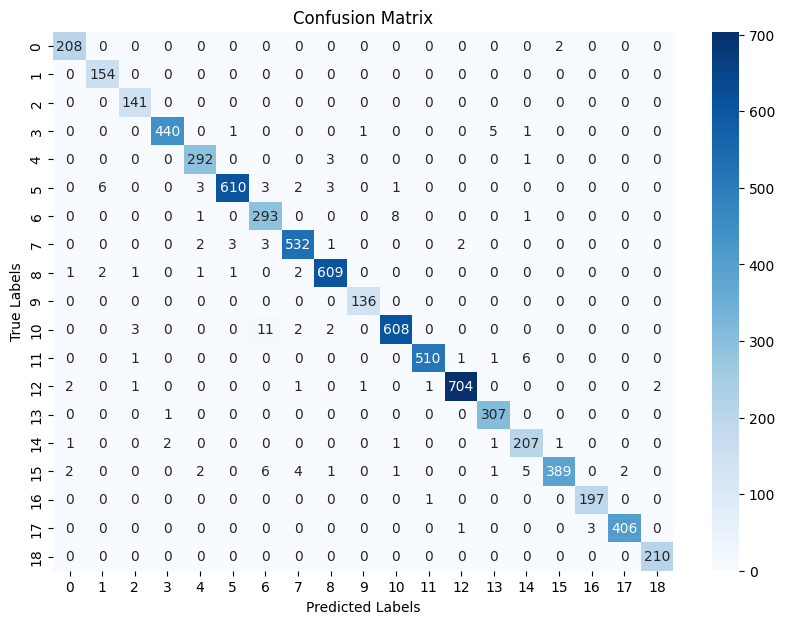

In [51]:
train_infer_loss, train_infer_precision, train_infer_recall, train_infer_accuracy, train_infer_overall_accuracy, train_infer_conf_matrix = validate_with_metrics(model, criterion, train_infer_loader, device, num_classes)
print_metrics(train_infer_loss, train_infer_precision, train_infer_recall, train_infer_accuracy, train_infer_overall_accuracy, train_infer_conf_matrix, num_classes)

Validation Loss: 0.0106
Overall Accuracy: 0.8641

Class-wise Metrics:
+-------+-----------+--------+----------+
| Class | Precision | Recall | Accuracy |
+-------+-----------+--------+----------+
|   0   |  0.8701   | 0.9926 |  0.9926  |
|   1   |  0.5286   | 0.7551 |  0.7551  |
|   2   |  0.9213   | 0.8119 |  0.8119  |
|   3   |  0.9134   | 0.9098 |  0.9098  |
|   4   |  0.8739   | 0.8517 |  0.8517  |
|   5   |  0.9276   | 0.6555 |  0.6555  |
|   6   |  0.8105   | 0.8973 |  0.8973  |
|   7   |  0.8918   | 0.7828 |  0.7828  |
|   8   |  0.6930   | 0.9685 |  0.9685  |
|   9   |  0.7386   | 0.8667 |  0.8667  |
|  10   |  0.8034   | 0.9171 |  0.9171  |
|  11   |  0.9645   | 0.8716 |  0.8716  |
|  12   |  0.9265   | 0.8502 |  0.8502  |
|  13   |  0.8699   | 0.9304 |  0.9304  |
|  14   |  0.7624   | 0.8021 |  0.8021  |
|  15   |  0.9167   | 0.8311 |  0.8311  |
|  16   |  0.9211   | 0.9722 |  0.9722  |
|  17   |  0.9799   | 0.9751 |  0.9751  |
|  18   |  0.9461   | 0.9294 |  0.9294  |
+-----

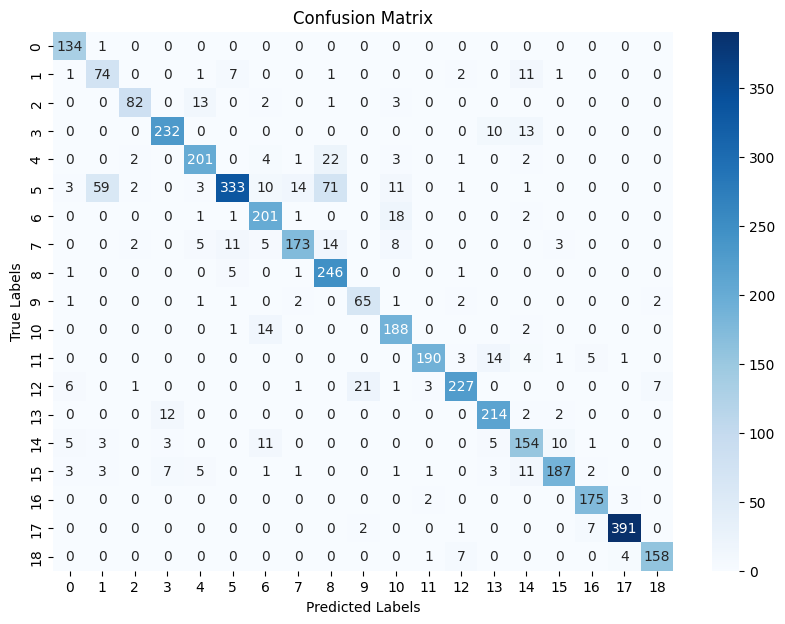

In [54]:
val_infer_loss, val_infer_precision, val_infer_recall, val_infer_accuracy, val_infer_overall_accuracy, val_infer_conf_matrix = validate_with_metrics(model, criterion, val_infer_loader, device, num_classes)
print_metrics(val_infer_loss, val_infer_precision, val_infer_recall, val_infer_accuracy, val_infer_overall_accuracy, val_infer_conf_matrix, num_classes)

In [ ]:
train_infer_loss, train_infer_topk_acc

In [ ]:
val_infer_loss, val_infer_topk_acc

Validation Loss: 0.0550
Overall Accuracy: 0.9847

Class-wise Metrics:
+-------+-----------+--------+----------+
| Class | Precision | Recall | Accuracy |
+-------+-----------+--------+----------+
|   0   |  0.9697   | 0.9897 |  0.9897  |
|   1   |  0.9867   | 0.9737 |  0.9737  |
|   2   |  1.0000   | 0.9726 |  0.9726  |
|   3   |  0.9899   | 0.9949 |  0.9949  |
|   4   |  0.9524   | 1.0000 |  1.0000  |
|   5   |  0.9969   | 0.9907 |  0.9907  |
|   6   |  0.9504   | 0.9504 |  0.9504  |
|   7   |  1.0000   | 0.9725 |  0.9725  |
|   8   |  0.9887   | 1.0000 |  1.0000  |
|   9   |  0.9697   | 1.0000 |  1.0000  |
|  10   |  0.9710   | 0.9669 |  0.9669  |
|  11   |  0.9950   | 0.9710 |  0.9710  |
|  12   |  0.9964   | 0.9894 |  0.9894  |
|  13   |  0.9817   | 0.9938 |  0.9938  |
|  14   |  0.9597   | 0.9754 |  0.9754  |
|  15   |  0.9891   | 0.9630 |  0.9630  |
|  16   |  0.9828   | 1.0000 |  1.0000  |
|  17   |  0.9956   | 1.0000 |  1.0000  |
|  18   |  0.9913   | 1.0000 |  1.0000  |
+-----

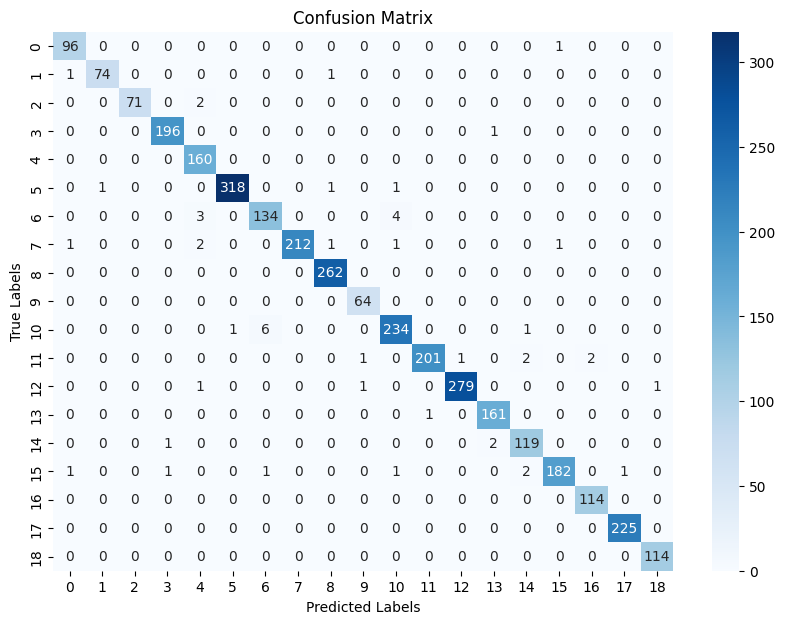

In [36]:
image_size = 300
batch_size = 32
num_workers = 4
num_classes=19
val_dataset = load_dataset('/kaggle/working/data/data_new/test', image_size, "test");
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
device = "cuda" if torch.cuda.is_available() else "cpu"
train_class_counts = count_images_in_classes('/kaggle/working/data/data_new/train')
total_train_images = sum(train_class_counts.values())
class_weights = calculate_class_weights(train_class_counts, total_train_images)
class_weights_tensor = torch.tensor(list(class_weights.values())).float().to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
model = get_model('efficientnet_b3', num_classes=len(class_names), parallel=False)
    
model.to(device)
model.load_state_dict(torch.load('/kaggle/working/clothes_efficientnet_b3_56.pth', map_location=torch.device(device), weights_only=False))
val_loss, precision, recall, accuracy, overall_accuracy, conf_matrix = validate_with_metrics(model, criterion, val_loader, device, num_classes)
print_metrics(val_loss, precision, recall, accuracy, overall_accuracy, conf_matrix, num_classes)

Validation Loss: 0.4842
Overall Accuracy: 0.8429

Class-wise Metrics:
+-------+-----------+--------+----------+
| Class | Precision | Recall | Accuracy |
+-------+-----------+--------+----------+
|   0   |  0.8889   | 0.8000 |  0.8000  |
|   1   |  0.7500   | 0.9000 |  0.9000  |
|   2   |  0.6923   | 0.9000 |  0.9000  |
|   3   |  1.0000   | 0.9000 |  0.9000  |
|   4   |  0.8000   | 0.4000 |  0.4000  |
|   5   |  1.0000   | 0.9000 |  0.9000  |
|   6   |  0.8000   | 0.8000 |  0.8000  |
|   7   |  0.9000   | 0.9000 |  0.9000  |
|   8   |  0.9091   | 1.0000 |  1.0000  |
|   9   |  0.9000   | 0.9000 |  0.9000  |
|  10   |  0.9091   | 1.0000 |  1.0000  |
|  11   |  0.7273   | 0.8000 |  0.8000  |
|  12   |  0.8000   | 0.7273 |  0.7273  |
|  13   |  0.7143   | 1.0000 |  1.0000  |
|  14   |  0.7143   | 1.0000 |  1.0000  |
|  15   |  1.0000   | 0.8000 |  0.8000  |
|  16   |  1.0000   | 0.7000 |  0.7000  |
|  17   |  0.8889   | 0.8000 |  0.8000  |
|  18   |  0.8889   | 0.8000 |  0.8000  |
+-----

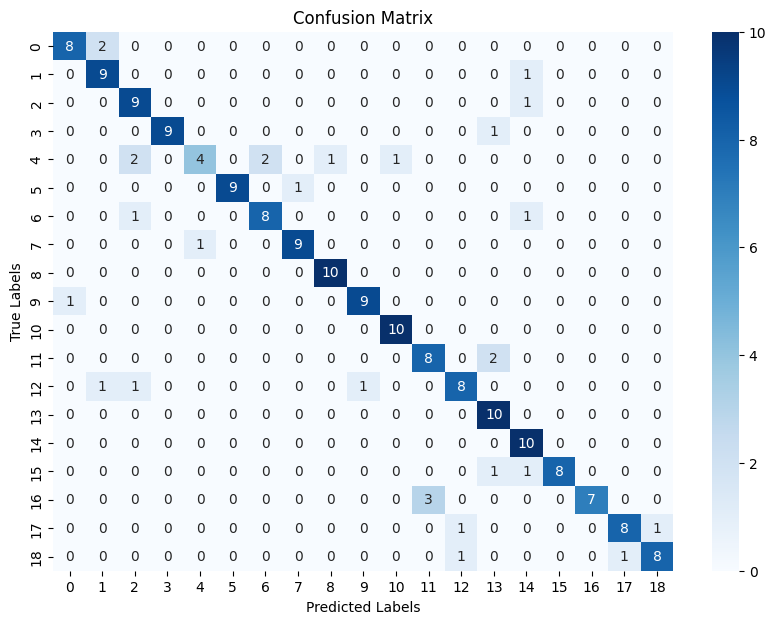

In [30]:
image_size = 300
batch_size = 32
num_workers = 4
num_classes=19
val_dataset = load_dataset('/kaggle/working/new_test_cut', image_size, "test");
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
device = "cuda" if torch.cuda.is_available() else "cpu"
train_class_counts = count_images_in_classes('/kaggle/working/data/data_new/train')
total_train_images = sum(train_class_counts.values())
class_weights = calculate_class_weights(train_class_counts, total_train_images)
class_weights_tensor = torch.tensor(list(class_weights.values())).float().to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
model = get_model('efficientnet_b3', num_classes=len(class_names), parallel=False)
    
model.to(device)
model.load_state_dict(torch.load('/kaggle/working/clothes_efficientnet_b3_21.pth', map_location=torch.device(device), weights_only=False))
val_loss, precision, recall, accuracy, overall_accuracy, conf_matrix = validate_with_metrics(model, criterion, val_loader, device, num_classes)
print_metrics(val_loss, precision, recall, accuracy, overall_accuracy, conf_matrix, num_classes)

Validation Loss: 0.3700
Overall Accuracy: 0.8953

Class-wise Metrics:
+-------+-----------+--------+----------+
| Class | Precision | Recall | Accuracy |
+-------+-----------+--------+----------+
|   0   |  1.0000   | 0.8000 |  0.8000  |
|   1   |  0.8333   | 1.0000 |  1.0000  |
|   2   |  1.0000   | 0.9000 |  0.9000  |
|   3   |  1.0000   | 1.0000 |  1.0000  |
|   4   |  0.7500   | 0.6000 |  0.6000  |
|   5   |  0.9000   | 0.9000 |  0.9000  |
|   6   |  0.8750   | 0.7000 |  0.7000  |
|   7   |  1.0000   | 0.8000 |  0.8000  |
|   8   |  0.8333   | 1.0000 |  1.0000  |
|   9   |  0.9000   | 0.9000 |  0.9000  |
|  10   |  0.8333   | 1.0000 |  1.0000  |
|  11   |  0.8333   | 1.0000 |  1.0000  |
|  12   |  1.0000   | 0.9091 |  0.9091  |
|  13   |  1.0000   | 1.0000 |  1.0000  |
|  14   |  0.7143   | 1.0000 |  1.0000  |
|  15   |  1.0000   | 1.0000 |  1.0000  |
|  16   |  1.0000   | 0.8000 |  0.8000  |
|  17   |  1.0000   | 0.7000 |  0.7000  |
|  18   |  0.7692   | 1.0000 |  1.0000  |
+-----

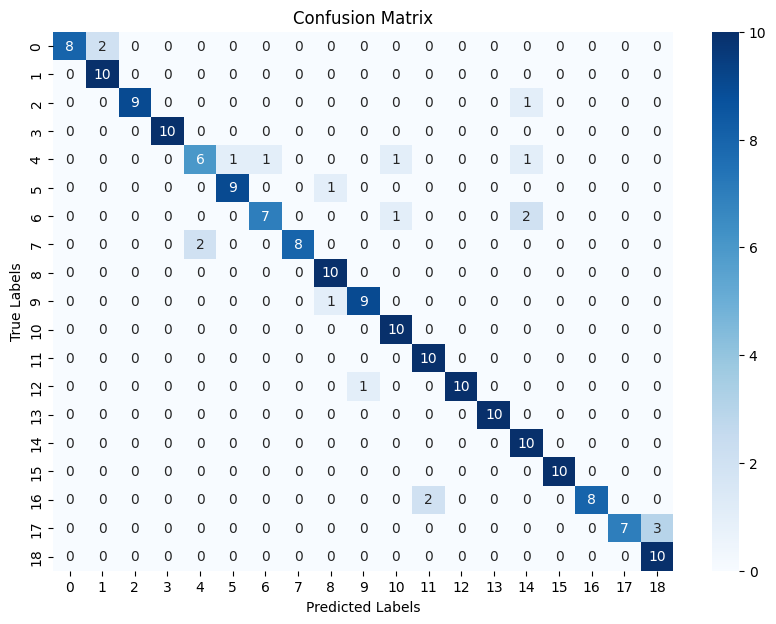

In [33]:
image_size = 300
batch_size = 32
num_workers = 4
num_classes=19
val_dataset = load_dataset('/kaggle/working/new_test_cut', image_size, "test");
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
device = "cuda" if torch.cuda.is_available() else "cpu"
train_class_counts = count_images_in_classes('/kaggle/working/data/data_new/train')
total_train_images = sum(train_class_counts.values())
class_weights = calculate_class_weights(train_class_counts, total_train_images)
class_weights_tensor = torch.tensor(list(class_weights.values())).float().to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
model = get_model('efficientnet_b3', num_classes=len(class_names), parallel=False)
    
model.to(device)
model.load_state_dict(torch.load('/kaggle/working/clothes_efficientnet_b3_56.pth', map_location=torch.device(device), weights_only=False))
val_loss, precision, recall, accuracy, overall_accuracy, conf_matrix = validate_with_metrics(model, criterion, val_loader, device, num_classes)
print_metrics(val_loss, precision, recall, accuracy, overall_accuracy, conf_matrix, num_classes)

In [29]:
!gdown 1qQ0feV-4cpAXHw4f8TFLCDaqUiikOfqV

Downloading...
From (original): https://drive.google.com/uc?id=1qQ0feV-4cpAXHw4f8TFLCDaqUiikOfqV
From (redirected): https://drive.google.com/uc?id=1qQ0feV-4cpAXHw4f8TFLCDaqUiikOfqV&confirm=t&uuid=40cb7d8e-cc7f-4d35-8a8d-c74144c66aec
To: /kaggle/working/clothes_efficientnet_b3_21.pth
100%|██████████████████████████████████████| 43.5M/43.5M [00:00<00:00, 52.7MB/s]
